In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0507MedianFilter_3_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.5
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 604ms/step - loss: 0.3572
Average validation loss: 0.6720904111862183
4/4 [==============================] - 6s 618ms/step - loss: 0.3572 - val_loss: 0.6721
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 9s 595ms/step - loss: 0.2773 - val_loss: 0.6721
Average validation loss: 0.39471426606178284
4/4 [==============================] - 9s 612ms/step - loss: 0.2773 - val_loss: 0.5334
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 591ms/step - loss: 0.2220 - val_loss: 0.5334
Average validation loss: 0.10568180680274963
4/4 [==============================] - 11s 610ms/step - loss: 0.2220 - val_loss: 0.3908
Saved model weights to 'c:\Users\user\Des

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 4s 560ms/step - loss: 0.0177
Average validation loss: 4.970889875721696e-06
8/8 [==============================] - 5s 572ms/step - loss: 0.0177 - val_loss: 4.9709e-06
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 9s 560ms/step - loss: 0.0160 - val_loss: 4.9709e-06
Average validation loss: 9.78804405349365e-06
8/8 [==============================] - 9s 571ms/step - loss: 0.0160 - val_loss: 7.3795e-06
Epoch 3/10
8/8 [==============================] - 14s 553ms/step - loss: 0.0156 - val_loss: 7.3795e-06
Average validation loss: 1.024440780383884e-05
8/8 [==============================] - 14s 564ms/step - loss: 0.0156 - val_loss: 8.3344e-06
Epoch 4/10
8/8 [==============================] - 18s 562ms/step - loss: 0.0153 - val_loss: 8.3344e-06
Average validation loss: 3.073310654144734e-05
8/8 [========

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 7s 565ms/step - loss: 0.0204
Average validation loss: 0.13893111050128937
12/12 [==============================] - 7s 576ms/step - loss: 0.0204 - val_loss: 0.1389
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 14s 562ms/step - loss: 0.0213 - val_loss: 0.1389
Average validation loss: 0.15621680596874885
12/12 [==============================] - 14s 572ms/step - loss: 0.0213 - val_loss: 0.1476
Epoch 3/10
12/12 [==============================] - 21s 569ms/step - loss: 0.0211 - val_loss: 0.1476
Average validation loss: 0.24177535521936835
12/12 [==============================] - 21s 582ms/step - loss: 0.0211 - val_loss: 0.1790
Epoch 4/10
12/12 [==============================] - 28s 573ms/step - loss: 0.0211 - val_loss: 0.1790
Average validation loss: 0.034619456452977225
12/12 [====================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 9s 572ms/step - loss: 0.0221
Average validation loss: 0.0932366898564041
16/16 [==============================] - 9s 583ms/step - loss: 0.0221 - val_loss: 0.0932
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 18s 569ms/step - loss: 0.0217 - val_loss: 0.0932
Average validation loss: 0.11146137415698831
16/16 [==============================] - 19s 579ms/step - loss: 0.0217 - val_loss: 0.1023
Epoch 3/10
16/16 [==============================] - 28s 570ms/step - loss: 0.0214 - val_loss: 0.1023
Average validation loss: 0.13057550069979484
16/16 [==============================] - 28s 579ms/step - loss: 0.0214 - val_loss: 0.1118
Epoch 4/10
16/16 [==============================] - 37s 572ms/step - loss: 0.0211 - val_loss: 0.1118
Average validation loss: 0.09403328258640364
16/16 [======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 11s 569ms/step - loss: 0.0136
Average validation loss: 0.0446715802885592
20/20 [==============================] - 12s 579ms/step - loss: 0.0136 - val_loss: 0.0447
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 23s 573ms/step - loss: 0.0131 - val_loss: 0.0447
Average validation loss: 0.1548691175368731
20/20 [==============================] - 23s 584ms/step - loss: 0.0131 - val_loss: 0.0998
Epoch 3/10
20/20 [==============================] - 35s 567ms/step - loss: 0.0127 - val_loss: 0.0998
Average validation loss: 0.0687527309946745
20/20 [==============================] - 35s 578ms/step - loss: 0.0127 - val_loss: 0.0894
Epoch 4/10
20/20 [==============================] - 46s 567ms/step - loss: 0.0124 - val_loss: 0.0894
Average validation loss: 0.02880188385024667
20/20 [======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 14s 565ms/step - loss: 0.0108
Average validation loss: 0.07249190161625545
24/24 [==============================] - 14s 575ms/step - loss: 0.0108 - val_loss: 0.0725
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 27s 567ms/step - loss: 0.0104 - val_loss: 0.0725
Average validation loss: 0.0558871328830719
24/24 [==============================] - 28s 578ms/step - loss: 0.0104 - val_loss: 0.0642
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 42s 575ms/step - loss: 0.0103 - val_loss: 0.0642
Average validation loss: 0.026606703487535317
24/24 [==============================] - 42s 586ms/step - loss: 0.0103 - val_loss: 0.0517
Saved model weights to

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 23s 569ms/step - loss: 0.0134
Average validation loss: 0.1423570580780506
40/40 [==============================] - 23s 581ms/step - loss: 0.0134 - val_loss: 0.1424
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 46s 567ms/step - loss: 0.0133 - val_loss: 0.1424
Average validation loss: 0.0759303143247962
40/40 [==============================] - 46s 577ms/step - loss: 0.0133 - val_loss: 0.1091
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 69s 568ms/step - loss: 0.0131 - val_loss: 0.1091
Average validation loss: 0.09308605492115021
40/40 [==============================] - 70s 579ms/step - loss: 0.0131 - val_loss: 0.1038
Epoch 4/10
40/40 [======

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 27s 571ms/step - loss: 0.0146
Average validation loss: 0.051845232024788857
48/48 [==============================] - 28s 581ms/step - loss: 0.0146 - val_loss: 0.0518
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 55s 570ms/step - loss: 0.0125 - val_loss: 0.0518
Average validation loss: 0.05228580063218639
48/48 [==============================] - 56s 580ms/step - loss: 0.0125 - val_loss: 0.0521
Epoch 3/10
48/48 [==============================] - 83s 570ms/step - loss: 0.0118 - val_loss: 0.0521
Average validation loss: 0.02976902659672002
48/48 [==============================] - 84s 580ms/step - loss: 0.0118 - val_loss: 0.0446
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_60.pth'.
Epoch 4/10
48/48 [===

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 32s 569ms/step - loss: 0.0099
Average validation loss: 0.43239693875823704
56/56 [==============================] - 32s 579ms/step - loss: 0.0099 - val_loss: 0.4324
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 64s 571ms/step - loss: 0.0089 - val_loss: 0.4324
Average validation loss: 0.12679640632513495
56/56 [==============================] - 65s 581ms/step - loss: 0.0089 - val_loss: 0.2796
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 97s 569ms/step - loss: 0.0082 - val_loss: 0.2796
Average validation loss: 0.18435361236333847
56/56 [==============================] - 97s 579ms/step - loss: 0.0082 - val_loss: 0.2478
Epoch 4/10
56/56 [====

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 36s 570ms/step - loss: 0.0085
Average validation loss: 0.35101046441923245
64/64 [==============================] - 37s 580ms/step - loss: 0.0085 - val_loss: 0.3510
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 74s 569ms/step - loss: 0.0073 - val_loss: 0.3510
Average validation loss: 0.017029062553774565
64/64 [==============================] - 74s 579ms/step - loss: 0.0073 - val_loss: 0.1840
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 111s 570ms/step - loss: 0.0062 - val_loss: 0.1840
Average validation loss: 0.012819676019717008
64/64 [==============================] - 111s 580ms/step - loss: 0.0062 - val_loss: 0.1270
Saved model weight

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 41s 573ms/step - loss: 0.0073
Average validation loss: 0.013276850326090224
72/72 [==============================] - 42s 583ms/step - loss: 0.0073 - val_loss: 0.0133
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 83s 573ms/step - loss: 0.0060 - val_loss: 0.0133
Average validation loss: 0.01824164644090666
72/72 [==============================] - 84s 583ms/step - loss: 0.0060 - val_loss: 0.0158
Epoch 3/10
72/72 [==============================] - 125s 568ms/step - loss: 0.0052 - val_loss: 0.0158
Average validation loss: 0.0181815713747508
72/72 [==============================] - 126s 578ms/step - loss: 0.0052 - val_loss: 0.0166
Epoch 4/10
72/72 [==============================] - 167s 571ms/step - loss: 0.0050 - val_loss: 0.0166
Average validation loss: 0.0743847226517068
72/72 [=================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 46s 570ms/step - loss: 0.0071
Average validation loss: 0.013247294537723064
80/80 [==============================] - 46s 579ms/step - loss: 0.0071 - val_loss: 0.0132
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 92s 568ms/step - loss: 0.0055 - val_loss: 0.0132
Average validation loss: 0.010059092461597174
80/80 [==============================] - 93s 578ms/step - loss: 0.0055 - val_loss: 0.0117
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 138s 568ms/step - loss: 0.0050 - val_loss: 0.0117
Average validation loss: 0.028747875103726984
80/80 [==============================] - 139s 578ms/step - loss: 0.0050 - val_loss: 0.0174
Epoch 4/10
80/8

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 55s 574ms/step - loss: 0.0097
Average validation loss: 0.020881886458179604
96/96 [==============================] - 56s 584ms/step - loss: 0.0097 - val_loss: 0.0209
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 111s 569ms/step - loss: 0.0076 - val_loss: 0.0209
Average validation loss: 0.023123593350950006
96/96 [==============================] - 112s 579ms/step - loss: 0.0076 - val_loss: 0.0220
Epoch 3/10
96/96 [==============================] - 166s 571ms/step - loss: 0.0065 - val_loss: 0.0220
Average validation loss: 0.028614973964370922
96/96 [==============================] - 167s 580ms/step - loss: 0.0065 - val_loss: 0.0242
Epoch 4/10
96/96 [==============================] - 222s 568ms/step - loss: 0.0058 - val_loss: 0.0242
Average validation loss: 0.030701423307618825
96/96 [=========

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 72s 600ms/step - loss: 0.0075
Average validation loss: 0.008054046705365182
120/120 [==============================] - 73s 611ms/step - loss: 0.0075 - val_loss: 0.0081
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 146s 606ms/step - loss: 0.0061 - val_loss: 0.0081
Average validation loss: 0.06280451066199547
120/120 [==============================] - 147s 616ms/step - loss: 0.0061 - val_loss: 0.0354
Epoch 3/10
120/120 [==============================] - 221s 611ms/step - loss: 0.0052 - val_loss: 0.0354
Average validation loss: 0.007263779516786902
120/120 [==============================] - 222s 621ms/step - loss: 0.0052 - val_loss: 0.0260
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_150.pth'.
Ep

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 88s 613ms/step - loss: 0.0054
Average validation loss: 0.008657174754059978
144/144 [==============================] - 90s 624ms/step - loss: 0.0054 - val_loss: 0.0087
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 178s 612ms/step - loss: 0.0047 - val_loss: 0.0087
Average validation loss: 0.016267493360727612
144/144 [==============================] - 180s 623ms/step - loss: 0.0047 - val_loss: 0.0125
Epoch 3/10
144/144 [==============================] - 268s 614ms/step - loss: 0.0041 - val_loss: 0.0125
Average validation loss: 0.009641682167259406
144/144 [==============================] - 269s 624ms/step - loss: 0.0041 - val_loss: 0.0115
Epoch 4/10
144/144 [==============================] - 357s 610ms/step - loss: 0.0037 - val_loss: 0.0115
Average validation loss: 0.009449254404494746
14

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 90s 564ms/step - loss: 0.0044
Average validation loss: 0.018179596323170698
160/160 [==============================] - 92s 573ms/step - loss: 0.0044 - val_loss: 0.0182
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 182s 564ms/step - loss: 0.0038 - val_loss: 0.0182
Average validation loss: 0.005812035374710511
160/160 [==============================] - 184s 574ms/step - loss: 0.0038 - val_loss: 0.0120
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 274s 564ms/step - loss: 0.0033 - val_loss: 0.0120
Average validation loss: 0.00659704190160113
160/160 [==============================] - 276s 574ms/step - loss: 0.0033 - val_loss: 0.0102
Ep

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 113s 564ms/step - loss: 0.0069
Average validation loss: 0.012179168675793335
200/200 [==============================] - 115s 575ms/step - loss: 0.0069 - val_loss: 0.0122
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 228s 567ms/step - loss: 0.0056 - val_loss: 0.0122
Average validation loss: 0.008075523758307099
200/200 [==============================] - 230s 577ms/step - loss: 0.0056 - val_loss: 0.0101
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 344s 567ms/step - loss: 0.0048 - val_loss: 0.0101
Average validation loss: 0.008265493202434299
200/200 [==============================] - 346s 577ms/step - loss: 0.0048 - val_loss: 0.0095

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:24 - loss: 7.7611e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 136s 566ms/step - loss: 0.0049
Average validation loss: 0.008132603432750329
240/240 [==============================] - 138s 576ms/step - loss: 0.0049 - val_loss: 0.0081
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_50\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 274s 567ms/step - loss: 0.0039 - val_loss: 0.0081
Average validation loss: 0.008484800834048655
240/240 [==============================] - 277s 577ms/step - loss: 0.0039 - val_loss: 0.0083
Epoch 3/10
240/240 [==============================] - 413s 568ms/step - loss: 0.0034 - val_loss: 0.0083
Average validation loss: 0.008538322480065592
240/240 [==============================] - 415s 578ms/step - loss: 0.0034 - val_loss: 0.0084
Epoch 4/10
240/240 [==============================] - 551s 566ms/step - loss: 0.0030 - val_loss: 0.0084
Average validation loss: 0.008399445083599251


train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.07125477493054745, 0.07012427239541509, 0.1642926525618488, 0.14249908131742628, 0.12492653649453601, 0.07964293792167519, 0.07242761423500671, 0.046648032499213225, 0.07885698481866636, 0.04369643230563312, 0.07588791298370366, 0.04767240741346559, 0.017296337514194834, 0.010296930856998858, 0.007562394505812225, 0.005253147326072801, 0.005788073995786021, 0.005414385728857007]
std_val_losses =  [0.13661710770210525, 0.06254635507151285, 0.14785267711796488, 0.11333667479532228, 0.07333860829466732, 0.08633982429334888, 0.08440732421085714, 0.03784655901443084, 0.10537761469827661, 0.06950645765169385, 0.11265102284584991, 0.08635432181636471, 0.015015857350245614, 0.011695948945427454, 0.008191471496418268, 0.002784635046583452, 0.0024570926434239275, 0.002642976087008515]


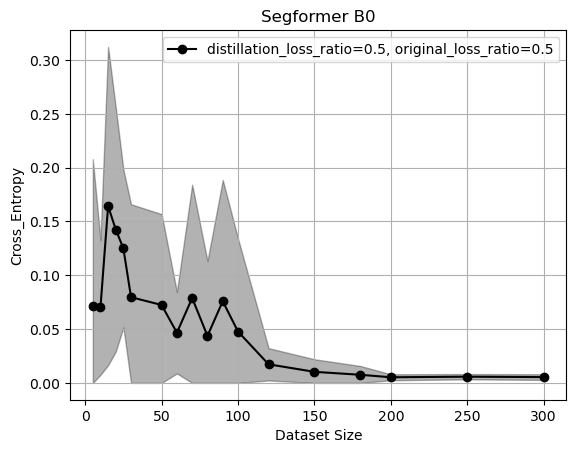

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()